In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib widget
import pyobs

<font size="3">
    
# Binning

$\def\O{\mathcal O}$
$\def\Obar{\overline \O}$
$\def\tauexp{\tau_\mathrm{exp}}$
$\def\dObar{\delta \Obar}$
$\def\cov{\mathrm{cov}}$
$\def\fbar{\overline f}$
$\def\var{\mathrm{var}}$
    
Let us imagine to define $\O^b$ as the average over $B$ consecutive measurements in Markov time of $\O(i)$, from configuration with index $i=b B$ up to $i=B(b+1)$, namely

\begin{equation}
    \O^b = \frac1B \sum_{i=Bb}^{B(b+1)} \O(i)
\end{equation}

Alternatively we may think in terms of block averages over small sets of space-time points, for the master-field analysis. We indicate with $N_B=N/B$ the number of bins or blocks.

Central values are unaffected by this procedure

\begin{equation}
\Obar = \frac{1}{N} \sum_i \O(i) = \frac{B}{N} \sum_b \O^b
\end{equation}

Our goal now is to calculate the error without the complications of the Gamma method, but with the unbiased naive estimator

\begin{equation}
    \var[\Obar] \equiv \frac{1}{N_B(N_B-1)} \sum_b [\O^b - \Obar]^2
\end{equation}

In presence of strong autocorrelations, or correlations in space-time, the block/bin size should be increased until we have resummed such effects and the variance has reached a plateau; at the same time we should guarantee that enough samples $N_B$ are still available. The latter controls the error of the error, which is expected to scale as $\sqrt{B/(2N)}$ (see [Wolff]).

In [2]:
N = 5000 # number of configs
mu = 3.14 # central values
cov = (mu*0.01)**2 # error^2

# autocorrelation time
tau = 7.0

rng = pyobs.random.generator('Mattia Bruno')
data = rng.markov_chain(mu,cov,tau,N)

obs = pyobs.observable()
obs.create('a', data)

Random generator initialized with seed = 2861754801 [Mattia Bruno]


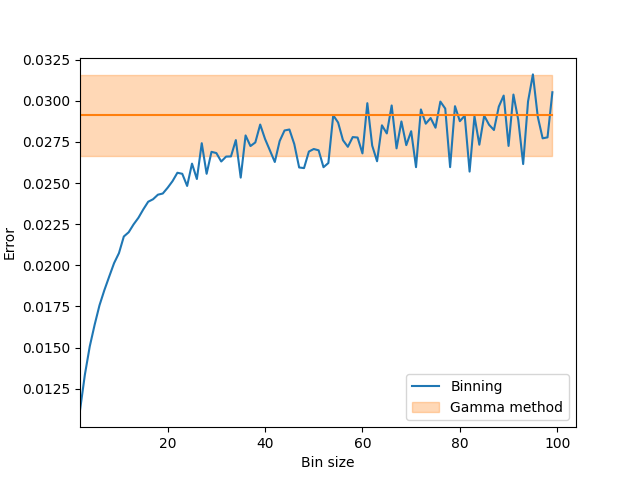

In [3]:
def bin_data(data, B):
    n = len(data)
    m = n//B
    return np.mean(np.reshape(data[0:m*B],(m,B)), axis=1)

def error(data, avg=None):
    N = len(data)
    if avg is None:
        avg = np.mean(data)
    return np.sqrt(np.sum((data - avg)**2)/(N-1)/N)

binsize = np.arange(2,100)

plt.figure()
plt.plot(binsize, [error(bin_data(data, b)) for b in binsize], label='Binning')

e = obs.error()[1][0]
de = obs.error_of_error()[0]
plt.plot([min(binsize), max(binsize)], [obs.error()[1]]*2, '-', color='C1')
plt.fill_between([min(binsize), max(binsize)], [e+de]*2, [e-de]*2, alpha=0.3, color='C1',label='Gamma method')

plt.legend(loc='lower right')
plt.xlabel('Bin size')
plt.ylabel('Error')
plt.xlim(2,)

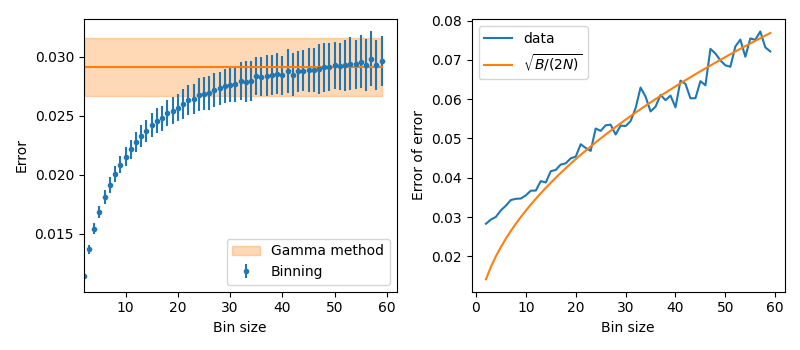

In [4]:
binsize = np.arange(2,60)

be = []
for r in range(50):
    _data = rng.markov_chain(mu,cov,tau,N)
    be += [[error(bin_data(_data,b)) for b in binsize]]
be = np.array(be)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3.5))

val = np.mean(be, axis=0)
err = np.var(be, axis=0)**0.5
ax1.errorbar(binsize, val, err, fmt='.', label='Binning')
ax1.set_xlim(2,)

e = obs.error()[1][0]
de = obs.error_of_error()[0]
ax1.plot([min(binsize), max(binsize)], [obs.error()[1]]*2, '-', color='C1')
ax1.fill_between([min(binsize), max(binsize)], [e+de]*2, [e-de]*2, alpha=0.3, color='C1',label='Gamma method')

ax1.set_xlabel('Bin size')
ax1.legend()
ax1.set_ylabel('Error')

ax2.plot(binsize, err/val, label='data')
ax2.plot(binsize, (binsize/2/N)**0.5, label='$\sqrt{B/(2N)}$')
ax2.legend()
ax2.set_xlabel('Bin size')
ax2.set_ylabel('Error of error')

f.tight_layout()

<font size="3">

We study a derived quantity $F(\O)$.

The best estimator for the central value of $F$ is obtained like before from

\begin{equation}
    \fbar = F(\Obar) 
\end{equation}

By evaluating the function $F$ on every bin, $f^b = F(\O^b)$ we can calculate the error of $\fbar$ using

\begin{equation}
    \var(\fbar) = \frac{1}{N_B(N_B-1)} \sum_b \big( f^b - \fbar \big)^2
\end{equation}

If we Taylor expand $f^b$ around $\fbar$ we obtain

\begin{equation}
    \var(\fbar) = \frac{1}{N_B(N_B-1)} \sum_b\  [f'(\Obar)]^2 \ [\O^b - \Obar]^2 + \dots
\end{equation}

As we can see the average over the bins automatically calculates/approximates the derivatives that we used explicitly in the Gamma method. Since this approximation is achieved numerically, it subject to numerical instabilities, in particular to 
    
  * the size of the fluctuations of $[\O^b - \Obar]$ which in general is large for small values of $B$
    
    
  * the size of the derivatives which may further enhance it

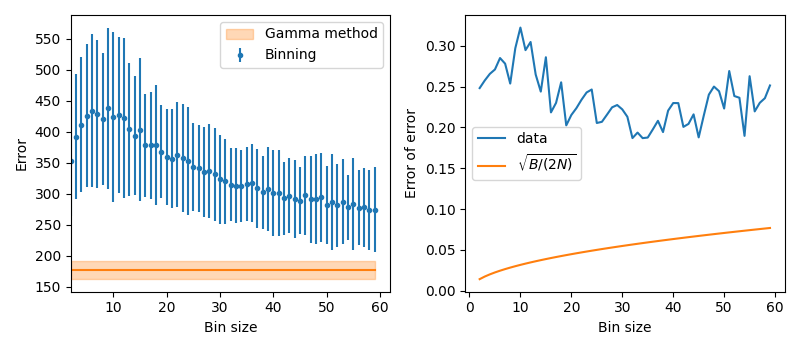

In [5]:
binsize = np.arange(2,60)

f = lambda x: np.exp(2.5*x)

be = []
for r in range(50):
    _data = rng.markov_chain(mu,cov,tau,N)
    be += [[error(f(bin_data(_data,b)), f(np.mean(_data))) for b in binsize]]
be = np.array(be)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3.5))

val = np.mean(be, axis=0)
err = np.var(be, axis=0)**0.5
ax1.errorbar(binsize, val, err, fmt='.', label='Binning')
ax1.set_xlim(2,)

e = pyobs.exp(2.5*obs).error()[1][0]
de = pyobs.exp(2.5*obs).error_of_error()[0]
ax1.plot([min(binsize), max(binsize)], [e]*2, '-', color='C1')
ax1.fill_between([min(binsize), max(binsize)], [e+de]*2, [e-de]*2, alpha=0.3, color='C1',label='Gamma method')

ax1.set_xlabel('Bin size')
ax1.legend()
ax1.set_ylabel('Error')

ax2.plot(binsize, err/val, label='data')
ax2.plot(binsize, (binsize/2/N)**0.5, label='$\sqrt{B/(2N)}$')
ax2.legend()
ax2.set_xlabel('Bin size')
ax2.set_ylabel('Error of error')

f.tight_layout()

<font size="3">
    
## Jackknife

$\def\jack{\mathrm{jack}}$

To mitigate numerical instabilities we introduce complementary bins, which are still labelled by the index $b$
\begin{equation}
    \O_\jack^b = \frac{N \Obar - \O^b}{N-B} = \frac{N_B \Obar - \O^b}{N_B-1} = \frac{1}{N-B} \sum_{i< Bb}^{i>=B(b+1)} \O(i)
\end{equation}

Note that for primary observables nothing changes
\begin{equation}
    \frac{1}{N_B} \sum_b \O_\jack^b = \frac{1}{N_B(N_B-1)} \sum_b \big(N_B \Obar - \O^b \big) = 
    \frac{N_B \Obar}{N_B-1} - \frac{\Obar}{N_B-1} = \Obar
\end{equation}

To keep the final variance unchanged we have to adapt the formula according to
\begin{equation}
    \var_\mathrm{jack}[\Obar] \equiv \frac{N_B-1}{N_B} \sum_b [\O_\jack^b - \Obar]^2 = \frac{N_B-1}{N_B} \sum_b \frac{[\O^b - \Obar]^2}{(N_B-1)^2} = \var[\Obar]
\end{equation}

Similar considerations for bin sizes and autocorrelations apply here too.

Note that with the following redefinition of the jackknife samples
\begin{equation}
    \O_\jack^b = \Obar + \frac{\Obar - \O^b}{\sqrt{N_B(N_B-1)}} 
\end{equation}
the variance simply becomes
\begin{equation}
    \var_\jack[\Obar] = \sum_b [\O_\jack^b - \Obar]^2 = \frac{1}{N_B(N_B-1)} \sum_b [\Obar - \O^b]^2
\end{equation}
    
For derived quantities one simply evaluates the function $F$ on every jackknife sample, $f^b = F(\O_\jack^b)$ and calculates the jackknife variance

\begin{equation}
    \var_\jack(\fbar) = \frac{N_B-1}{N_B} \sum_b \big( f^b - \fbar \big)^2
\end{equation}

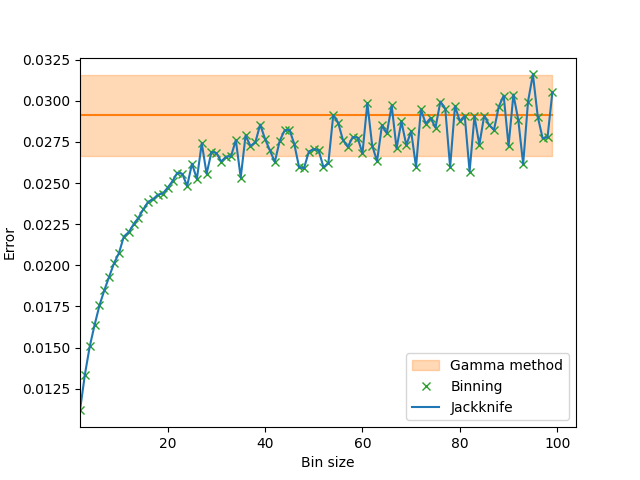

In [6]:
def jackknife(data, B):
    bindata = bin_data(data, B)
    NB = len(bindata)
    return (np.sum(bindata) - bindata)/(NB-1)
    
def jackknife_error(jbins, avg=None):
    NB = len(jbins)
    return error(jbins, avg) * (NB - 1)

binsize = np.arange(2,100)

plt.figure()
plt.xlabel('Bin size')
plt.ylabel('Error')

e = obs.error()[1][0]
de = obs.error_of_error()[0]
plt.plot([min(binsize), max(binsize)], [obs.error()[1]]*2, '-', color='C1')
plt.fill_between([min(binsize), max(binsize)], [e+de]*2, [e-de]*2, alpha=0.3, color='C1',label='Gamma method')

plt.plot(binsize, [error(bin_data(data, b)) for b in binsize], 'x', color='C2', label='Binning')
plt.plot(binsize, [jackknife_error(jackknife(data, b)) for b in binsize], color='C0', label='Jackknife')

plt.xlim(2,)
plt.legend(loc='lower right')

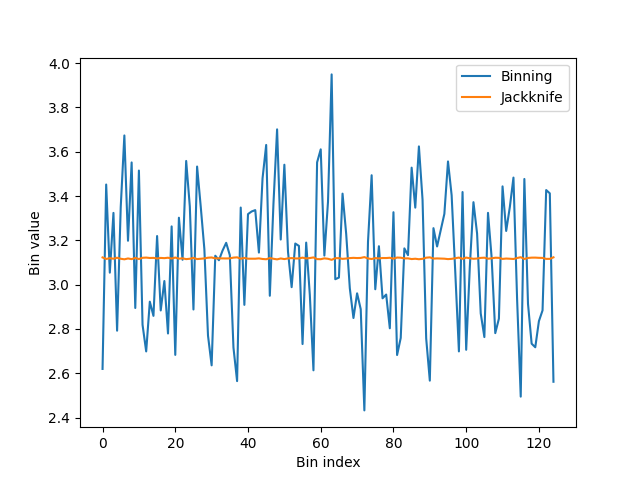

In [7]:
b = 40
plt.figure()
plt.plot(bin_data(data, b), label='Binning')
plt.plot(jackknife(data, b), label='Jackknife')
plt.xlabel('Bin index')
plt.ylabel('Bin value')
plt.legend()

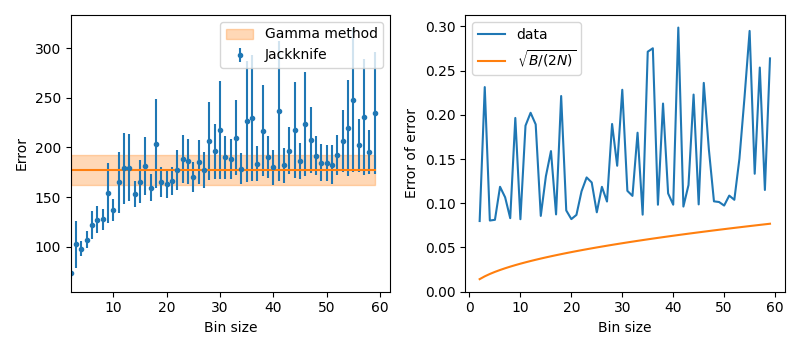

In [8]:
binsize = np.arange(2,60)

f = lambda x: np.exp(2.5*x)

je = []
for r in range(50):
    _data = rng.markov_chain(mu,cov,tau,N)
    je += [[jackknife_error(f(jackknife(_data,b)), f(np.mean(_data))) for b in binsize]]
je = np.array(je)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3.5))

val = np.mean(je, axis=0)
err = np.var(je, axis=0)**0.5
ax1.errorbar(binsize, val, err, fmt='.', label='Jackknife')
ax1.set_xlim(2,)

e = pyobs.exp(2.5*obs).error()[1][0]
de = pyobs.exp(2.5*obs).error_of_error()[0]
ax1.plot([min(binsize), max(binsize)], [e]*2, '-', color='C1')
ax1.fill_between([min(binsize), max(binsize)], [e+de]*2, [e-de]*2, alpha=0.3, color='C1',label='Gamma method')

ax1.set_xlabel('Bin size')
ax1.legend()
ax1.set_ylabel('Error')

ax2.plot(binsize, err/val, label='data')
ax2.plot(binsize, (binsize/2/N)**0.5, label='$\sqrt{B/(2N)}$')
ax2.legend()
ax2.set_xlabel('Bin size')
ax2.set_ylabel('Error of error')

f.tight_layout()

## Exercise: effective mass with jackknife

In [9]:
corr = pyobs.load('./pscorr.pyobs')
T = corr.shape[0]
pscorr_data = (corr.mean[:,None] + corr.delta['H400:H400r001'].delta).T

[Bison] : Reading file ./pscorr.pyobs
[Bison] : File created by mbruno at macthxbruno.local on Fri Oct  6 23:15:08 2023
[Bison] : Read 0.756943 MB at 50.9664 MB/s


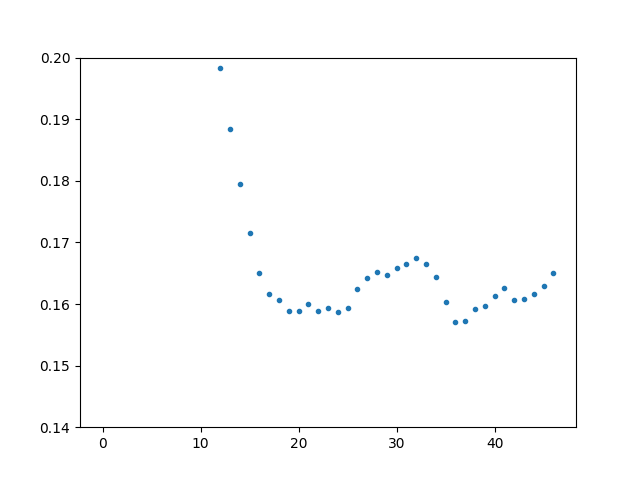

In [10]:
tax = []
me = []
dme = []

f = lambda x,y: np.log(x/y)

avg = np.mean(pscorr_data, axis=0)
for i in range(T//2):
    tax.append(i)
    me.append(f(avg[i], avg[i+1]))
    dme.append(0) #fill this line
    
plt.figure()
plt.errorbar(tax, me, dme, fmt='.')
plt.ylim(0.14,0.20)

<font size="3">
    
## Further considerations I

Let us imagine the situation where jackknife bins of an observable $\O^{b|B_1}$ have been created and passed to us without additional knowledge on how large the bin size $B_1$ was. How do we check if autocorrelations are properly taken into account? To still perform a reliable error estimation we proceed to a two-level jackknife strategy, where we jackknife the pre-binned data in a second level with bin size $B_2$ which we effectively control.

\begin{equation}
    \O_\jack^{b|B_2} = \frac{N \Obar - \O_\jack^{b|B_1}(N_{B_1}-1)}{N_{B_2}-1}
\end{equation}

We then apply the jackknife variance formula with the $(N_{B_2}-1)$ factor.
    
## Further considerations II

Finally we consider the more general situation where we have two observables $\O_{\jack, 1}^{b|B_1}$  and $\O_{\jack, 2}^{b'|B_2}$ with $b$ and $b'$ running on the respective bin indices. The two observables are from different ensembles and the question is how do we combine them, assuming to be interested in the binary operation $F(\O_1, \O_2)$?

If they come from different ensembles the solution is trivial: one calculates
\begin{equation}
    f_\jack^{b|B_1} = F(\O_{\jack, 1}^{b|B_1}, \Obar_2) \,, \quad
    f_\jack^{b'|B_2} = F(\Obar_1, \O_{\jack, 2}^{b|B_2} )
\end{equation}
and sums in quadrature the two variances. Alternatively one may formulate the same solution by extending the Monte-Carlo history of the two observables with their mean where they have no fluctuations:

\begin{equation}
    \O_{\jack,1}^{0|B_1}, \ \O_{\jack,1}^{1|B_1}, \ \O_{\jack,1}^{2|B_2}, \ \dots, \ \O_{\jack,1}^{N_{B_1}|B_1}, \ \overbrace{\Obar_1 , \dots \Obar_1}^{N_{B_2}}
\end{equation}

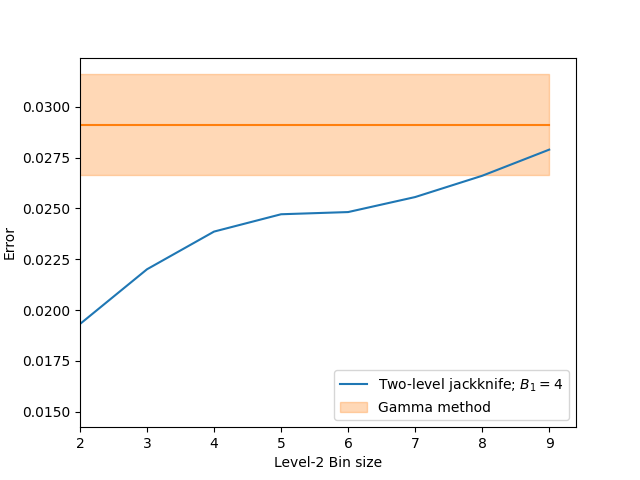

In [11]:
def two_level_jackknife(jbins, b):
    NB = len(jbins)
    return jackknife(jbins, b)*(NB-1)

binsize = np.arange(1,10)

jbins = jackknife(data, 4)

plt.figure()
plt.plot(binsize, [jackknife_error(two_level_jackknife(jbins, b)) for b in binsize], label='Two-level jackknife; $B_1=4$')

e = obs.error()[1][0]
de = obs.error_of_error()[0]
plt.plot([min(binsize), max(binsize)], [obs.error()[1]]*2, '-', color='C1')
plt.fill_between([min(binsize), max(binsize)], [e+de]*2, [e-de]*2, alpha=0.3, color='C1',label='Gamma method')

plt.legend(loc='lower right')
plt.xlabel('Level-2 Bin size')
plt.ylabel('Error')
plt.xlim(2,)